# Code for competition

In [8]:
import tensorflow as tf
import numpy as np
import os
import shutil
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare the environment

In [6]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Models metadata

In [10]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 128
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Online augmentation
Lets create the generators we'll need

In [11]:
train_data_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=(1, 1.5),
                                    #channel_shift_range=150,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    fill_mode='reflect',
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

Using flow_from_directory

In [21]:
# Paths
path = os.getcwd()
training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',    # Targets are directly converted into one-hot vectors
                                               shuffle=True,
                                               seed=seed)  

# Compute the class weights in order to balance loss during training
counter = Counter(train_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} 

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

print(class_weights)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.
{0: 2.8986486486486487, 1: 1.0094117647058825, 2: 1.0412621359223302, 3: 1.0514705882352942, 4: 1.0117924528301887, 5: 2.4237288135593222, 6: 1.0, 7: 1.0566502463054188}


### Models definition functions

In [15]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)
    
    x = tfkl.Dense(
        units = 512,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [19]:
model = build_tl_model(input_shape)

# Use the supernet only as feature extractor (eventually apply fine tuning)
model.get_layer('inception_v3').trainable = True
for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
  layer.trainable=False

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 gap_dropout (Dropout)       (None, 2048)              0         
                                                                 
 classifier (Dense)          (None, 512)               1049088   
                                                                 
 output_layer (Dense)        (None, 8)                 4104      
                                                          

### Train the model

In [23]:
# Transfer learning preprocessing (to be included in the preprocessing)
#from tensorflow.keras.applications.vgg16 import preprocess_input
#X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
#X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(x=train_dataset,
                    epochs=epochs,                   # Only indicative since we set repeat in training and validation datasets
                    steps_per_epoch=len(train_gen),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/30
23/23 [==============================] - 30s 1s/step - loss: 2.7647 - accuracy: 0.1435 - val_loss: 272.7723 - val_accuracy: 0.1515
Epoch 2/30
16/23 [===================>..........] - ETA: 5s - loss: 2.4588 - accuracy: 0.1963

KeyboardInterrupt: 

### Plot training results

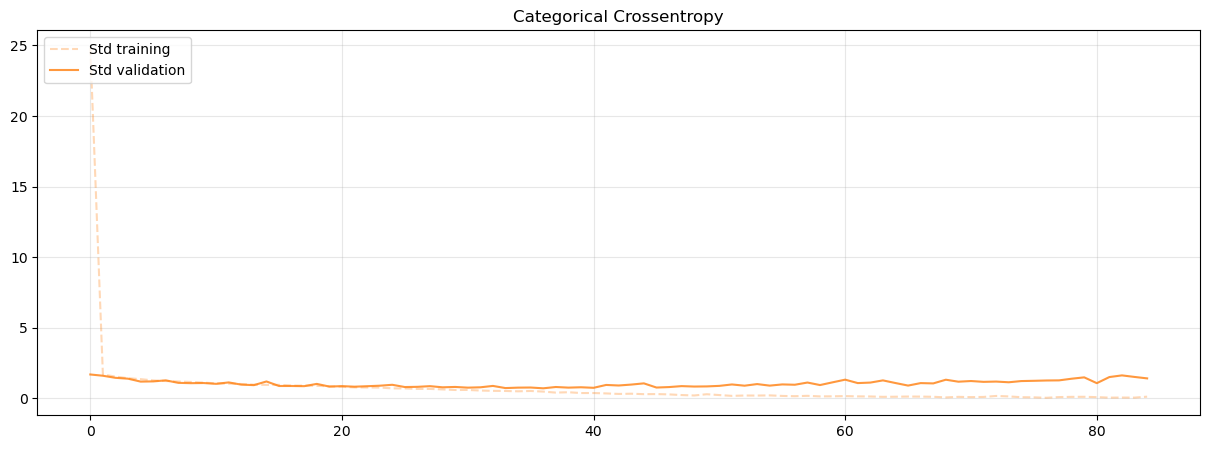

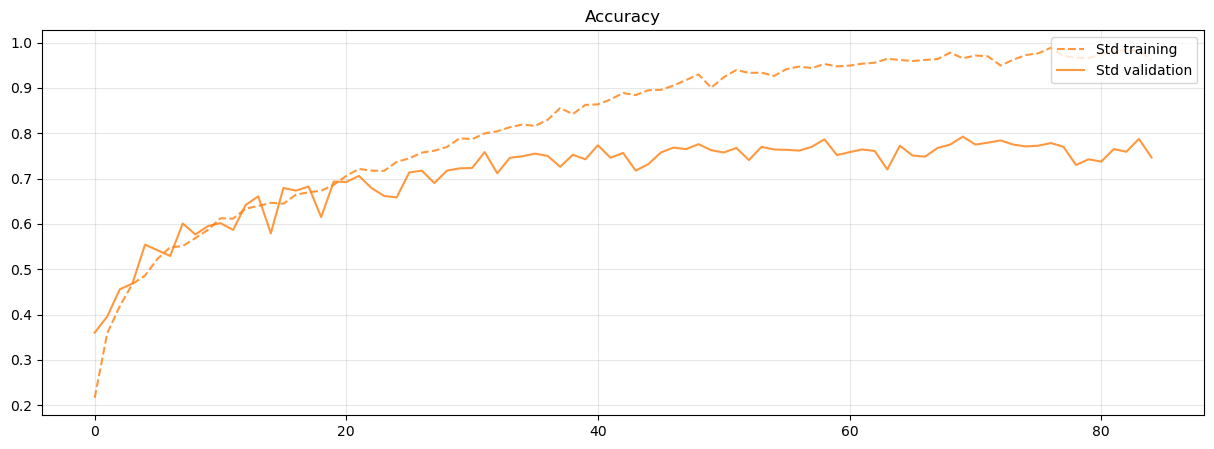

In [14]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

38/38 [==============================] - 5s 120ms/step
Accuracy: 0.7925
Precision: 0.7972
Recall: 0.7925
F1: [0.7692 0.7697 0.8    0.7932 0.7986 0.894  0.8702 0.651 ]


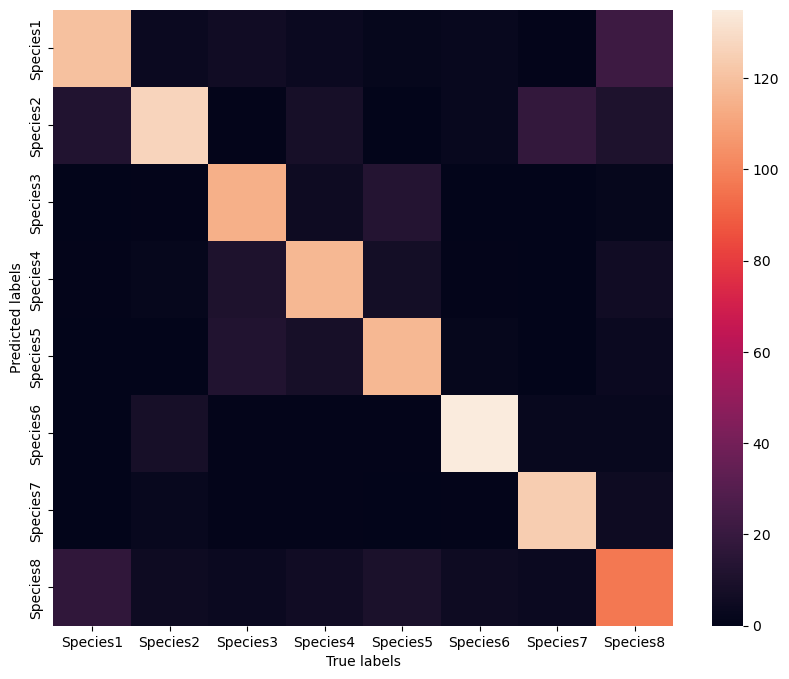

In [15]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [17]:
num_test_samples = 120

test_samples = []
test_targets = []
for i in range(0, len(labels)):
    for j in range(0, num_test_samples):
        test_samples.append(preprocess(ref_list[i][j]))
        test_targets.append(tfk.utils.to_categorical(i, len(labels)))
X_test = np.array(test_samples)
y_test = np.array(test_targets)


restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_test, y_test, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_test, y_test, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

30/30 - 4s - loss: 10.7756 - accuracy: 0.1250 - 4s/epoch - 135ms/step
30/30 - 4s - loss: 10.7756 - accuracy: 0.1250 - 4s/epoch - 124ms/step
No improvement!
